## Imports and Setup

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from collections import Counter
import itertools

In [38]:
train = pd.read_csv('../data/Customer-Support/Bitext_Sample_Customer_Service_Training_Dataset.csv')
valid = pd.read_csv('../data/Customer-Support/Bitext_Sample_Customer_Service_Validation_Dataset.csv')
test = pd.read_csv('../data/Customer-Support/Bitext_Sample_Customer_Service_Testing_Dataset.csv')

In [39]:
train.head()

,utterance,intent,category,tags
0,would it be possible to cancel the order I made?,cancel_order,ORDER,BIP
1,cancelling order,cancel_order,ORDER,BK
2,I need assistance canceling the last order I h...,cancel_order,ORDER,B
3,problem with canceling the order I made,cancel_order,ORDER,B
4,I don't know how to cancel the order I made,cancel_order,ORDER,B


In [40]:
number_of_intents = train['intent'].nunique()
print(f"Number of unique intents: {number_of_intents}")

Number of unique intents: 27


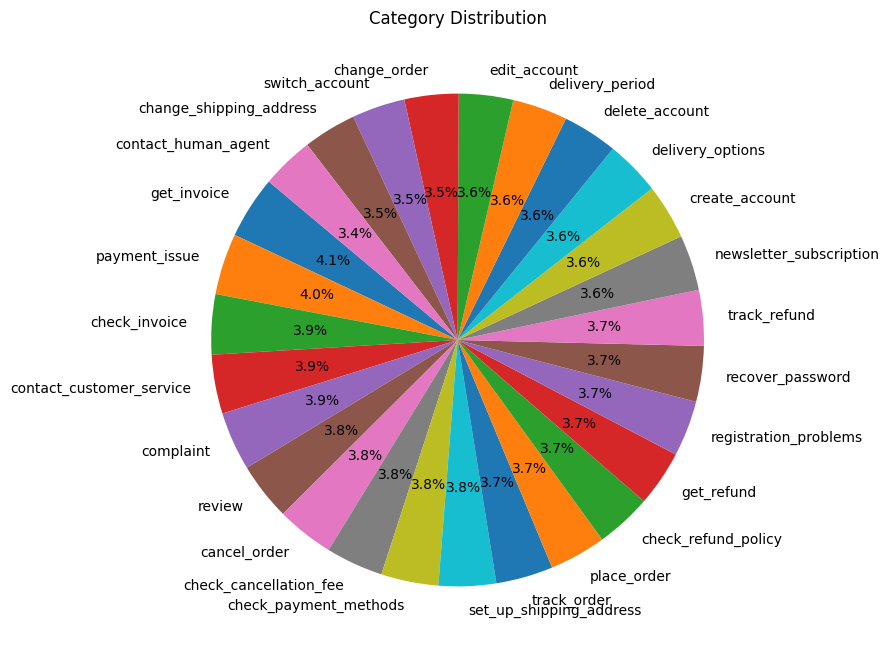

In [41]:
plt.figure(figsize=(8, 8))
plt.pie(train['intent'].value_counts(), labels=train['intent'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Category Distribution')
plt.show()

In [42]:
all_words = list(itertools.chain.from_iterable(train['utterance'].str.lower().str.split()))
word_counts = Counter(all_words)
print("Total unique words:", len(word_counts))

Total unique words: 803


In [43]:
common = word_counts.most_common(20)
print("Top 20 most common words:\n", common)

Top 20 most common words:
 [('i', 4830), ('to', 3900), ('the', 1723), ('help', 1674), ('a', 1294), ('do', 1284), ('my', 1238), ('me', 1167), ('can', 1164), ('how', 1115), ('check', 1013), ('what', 948), ('need', 871), ('know', 834), ('you', 807), ('assistance', 710), ('could', 662), ('want', 658), ('have', 633), ('an', 629)]


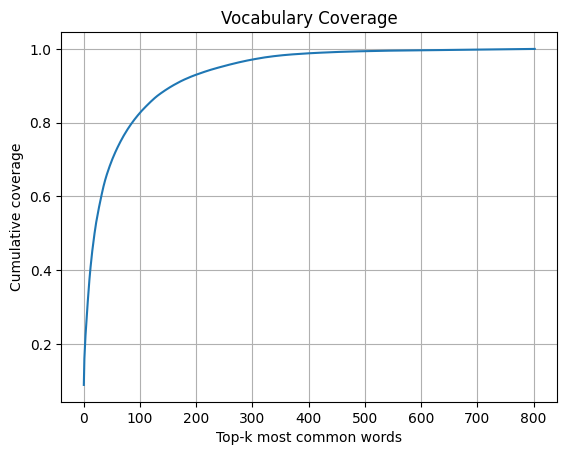

In [44]:
frequencies = np.array([count for word, count in word_counts.most_common()])
coverage = np.cumsum(frequencies) / np.sum(frequencies)

import matplotlib.pyplot as plt
plt.plot(coverage[:5000])
plt.xlabel("Top-k most common words")
plt.ylabel("Cumulative coverage")
plt.title("Vocabulary Coverage")
plt.grid(True)
plt.show()

Hence, through this we can come to the conclusion that the size of about 800 is sufficient for this dataset.

In [45]:
max_len = max(len(str(sen).split()) for sen in train['utterance'])
print("Max sequence length:", max_len)

Max sequence length: 15


In [46]:
vocab_size = 1000

text_vec = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=max_len,
)
text_vec.adapt(train['utterance'])

In [47]:
text_vec.adapt(train['utterance'])

In [48]:
X_train = text_vec(train['utterance'])

In [49]:
onehot_encoder = OneHotEncoder(sparse_output=False)
# Reshape to 2D array as required by OneHotEncoder
labels_encoded_train = onehot_encoder.fit_transform(train['intent'].values.reshape(-1, 1))
labels_encoded_valid = onehot_encoder.transform(valid['intent'].values.reshape(-1, 1))
labels_encoded_test = onehot_encoder.transform(test['intent'].values.reshape(-1, 1))

In [52]:
number_of_intents = labels_encoded_train.shape[1]
print(f"Number of unique intents after encoding: {number_of_intents}")

Number of unique intents after encoding: 27


In [54]:
embedding_dim = 32

model = tf.keras.Sequential([
    text_vec,
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True,
    ),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(number_of_intents, activation='softmax')
])